In [135]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.optimize import minimize
from datetime import datetime

%matplotlib inline

In [116]:
def d(St, K, t, T, r, q, sigma):
    '''
    d2 = d1 - sigma * np.sqrt(T-t)
    '''
    return (np.log(St/K) + (T-t) * (r - q + (sigma ** 2) * 0.5)) / (sigma * np.sqrt(T-t))

def N(d):
    '''
    Standard normal cumulative distribution function.
    e^{-qt} * N(d1) = delta of call option
    e^{-qt} * (N(d1) - 1) = delta of put option
    N(d2) = risk-neutral probability (S_T >= K) i.e. probability option expires ITM
    '''
    return norm.cdf(d)

In [117]:
def BSM_euro_call_value(St, K, t, T, r, q, sigma):
    '''
    Parameters
    -------------
    St: initial stock price
    K: strike price
    t: start date
    T: maturity date
    r: r_f
    q: dividend yield
    sigma: vol
    '''
    
    d1 = d(St, K, t, T, r, q, sigma)
    d2 = d1 - sigma * np.sqrt(T-t)
    
    return St * np.exp(-q * (T-t)) * N(d1) - K * np.exp(-r * (T-t)) * N(d2)

In [118]:
def BSM_euro_put_value(St, K, t, T, r, q, sigma):
    '''
    Parameters
    -------------
    St: initial stock price
    K: strike price
    t: start date
    T: maturity date
    r: r_f
    q: dividend yield
    sigma: vol
    '''
    
    d1 = d(St, K, t, T, r, q, sigma)
    d2 = d1 - sigma * np.sqrt(T-t)
    
    return K * np.exp(-r * (T-t)) * N(-d2) - St * np.exp(-q * (T-t)) * N(-d1)

    # --- alternatively, put option value can be derived from call option value ---
    # BSM_euro_call_value(St, K, t, T, r, q, sigma) - \
    # St * np.exp(-q * (T-t)) + np.exp(-r * (T-t)) * K

In [119]:
def vega(St, K, t, T, r, q, sigma):
    d1 = d(St, K, t, T, r, q, sigma)
    return norm.pdf(d1, 0.0, 1.0) * np.sqrt(T)

In [236]:
def imp_vol(St, K, t, T, r, q, option_val, sigma_est=0.5):
        
    def min_func(sigma_est, s):
        C0 = BSM_euro_call_value(St, K, t, T, r, q, sigma_est)
        return abs(C0 - option_val)
    
    res = minimize(min_func, 
                   x0=sigma_est, 
                   args=sigma_est,
                   tol=1e-4,
                   method='Nelder-Mead')
    
    return res.x[0]

In [237]:
St = 100.0   # index level
K = 100.0    # option strike
t = 0.0      # valuation date
T = 1.0      # maturity date
r = 0.05     # risk-less short rate
q = 0.02     # dividend yield
sigma = 0.2  # volatility

In [238]:
call_val = BSM_euro_call_value(St, K, t, T, r, q, sigma)
impl_vol = imp_vol(St, K, t, T, r, q, 9.2)

print('Call value: {}\nImplied Vol: {}'.format(call_val, impl_vol))

Call value: 9.227005508154036
Implied Vol: 0.1992889404296872


## Call and Put Option Values (Across Various Stock Prices)

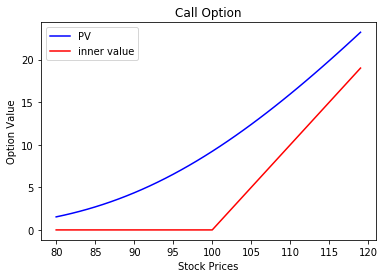

In [239]:
stock_prices = np.arange(80, 120)
call_values = []
terminal_call_values = []
for St in stock_prices:
    call_values.append(BSM_euro_call_value(St, K, t, T, r, q, sigma))
    terminal_call_values.append(max(St-K, 0))
    
plt.plot(stock_prices, call_values, color='b', label='PV')
plt.plot(stock_prices, terminal_call_values, color='r', label='inner value')
plt.xlabel('Stock Prices')
plt.ylabel('Option Value')
plt.title('Call Option')
plt.legend()

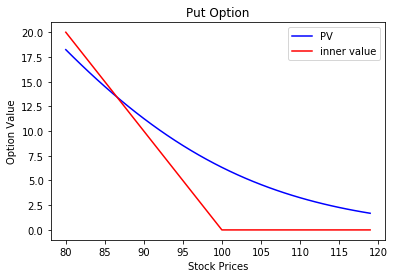

In [240]:
stock_prices = np.arange(80, 120)
put_values = []
terminal_put_values = []
for St in stock_prices:
    put_values.append(BSM_euro_put_value(St, K, t, T, r, q, sigma))
    terminal_put_values.append(max(K-St, 0))
    
plt.plot(stock_prices, put_values, color='b', label='PV')
plt.plot(stock_prices, terminal_put_values, color='r', label='inner value')
plt.xlabel('Stock Prices')
plt.ylabel('Option Value')
plt.title('Put Option')
plt.legend()

## Volatility Surface

Implied volatilites over various:
- strikes
- maturities

**Volatility smile** - OTM implied volatilities are higher than ATM
- more pronounced for short-term vs. long-term options

In [241]:
df = pd.read_excel('amd_2019_call_option_data.xlsx')
df.drop(['Contract Name', 'Last Trade Date', 'Change', '% Change', 'Volume', 'Open Interest'], 
        axis=1,
        inplace=True)
df['Price'] = np.round((df['Bid'] + df['Ask']) / 2, 2)
df.head()

,Strike,Last Price,Bid,Ask,Implied Volatility,Maturity,Price
0,22.0,8.60,9.40,9.45,1.5742,2019-09-07,9.43
1,22.5,7.60,8.80,8.90,1.3203,2019-09-07,8.85
2,23.0,8.15,8.35,8.50,1.4102,2019-09-07,8.43
3,24.0,7.70,7.40,7.45,1.2500,2019-09-07,7.43
4,25.0,6.70,6.40,6.45,1.0957,2019-09-07,6.43


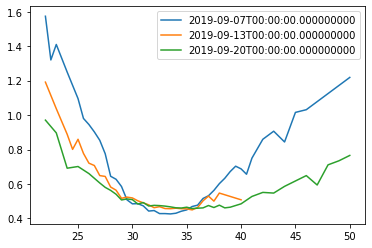

In [242]:
for T in df['Maturity'].unique():
    df_ = df[df['Maturity'] == T].copy()
    plt.plot(df_['Strike'], df_['Implied Volatility'], label=T)

plt.legend()

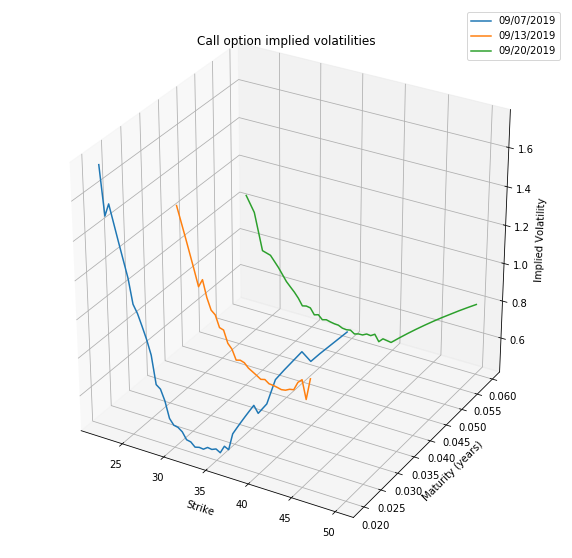

In [284]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')

St = 31.2    # index level
t = 0        # valuation date
r = 0.02     # risk-less short rate
# q = 0.01     # dividend yield

mat_dates = df['Maturity'].unique()

mat_vals = [len(pd.date_range(datetime.today(), maturity, freq='B'))/252 \
              for maturity in mat_dates]

impl_vol_mtx = []
tolerance = 0.05 # minimizer fails to find correct value, set lower threshold for impl vol

for mat_date, T in zip(mat_dates, mat_vals):
    df_ = df[df['Maturity']==mat_date].copy()
    strikes = df_['Strike'].values
    impl_vol_arr = []
    for K, price in zip(df_['Strike'].values, df_['Price'].values):
        i_vol = imp_vol(St, K, t, T, r, q, price, vol)
        if i_vol > tolerance:
            impl_vol_arr.append(imp_vol(St, K, t, T, r, q, price, 1.5))
        else:
            strikes = [x for x in strikes if x != K]
    
#     plt.plot(strikes, impl_vol_arr, label=pd.to_datetime(mat_date).strftime('%m/%d/%Y'))
    ax.plot(strikes, [T] * len(strikes), impl_vol_arr, label=pd.to_datetime(mat_date).strftime('%m/%d/%Y'))
    
ax.set_xlabel('Strike')
ax.set_ylabel('Maturity (years)')
ax.set_zlabel('Implied Volatility')
ax.set_title('Call option implied volatilities')
plt.legend()
